## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

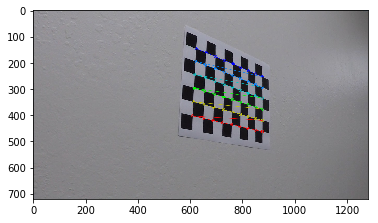

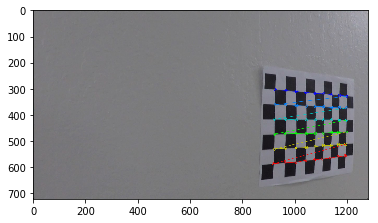

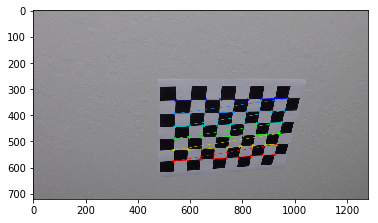

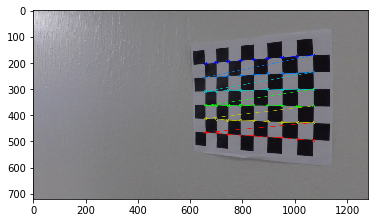

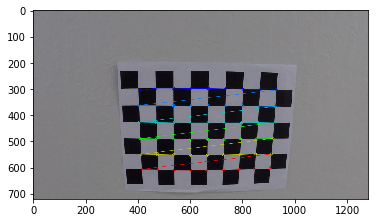

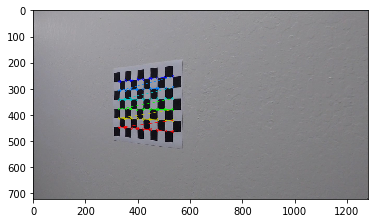

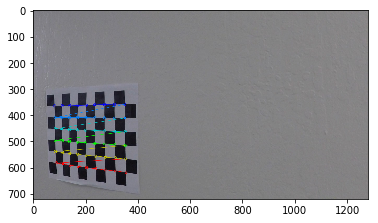

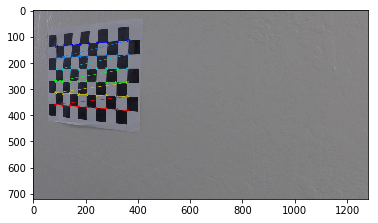

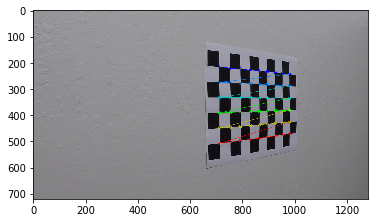

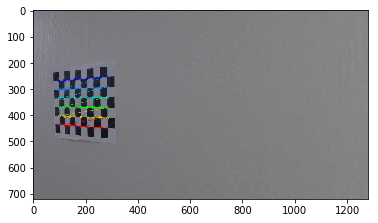

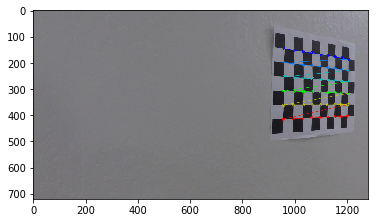

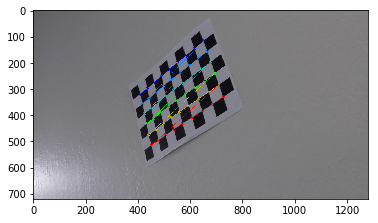

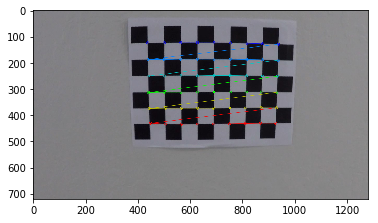

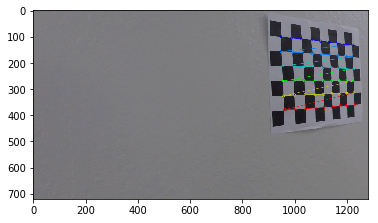

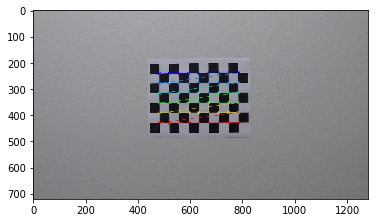

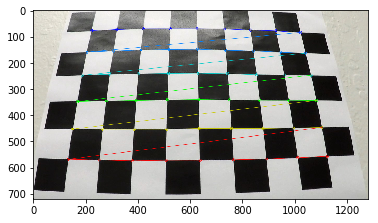

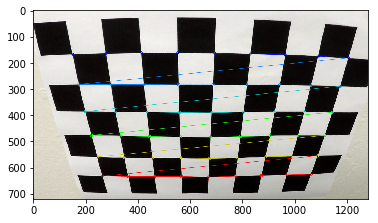

In [1]:
import numpy as np
import time
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# img = mpimg.imread(images[5])

# plt.figure()
# plt.imshow(img)
# plt.show()


# Step through the list and search for chessboard corners

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

        
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)    
# images = glob.glob('../camera_cal/calibration*.jpg')
# img = mpimg.imread(images[5])
# undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# # Plotting images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Original Distorted Calibration Image')
# ax1.imshow(img)

# ax2.set_title('Undistorted Calibration Image')
# ax2.imshow(undistorted)
# fname='../pipeline/undistorted_calibration_image.jpg'
# f.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='jpg',
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

## Second, I'll apply distortion correction on the raw images


In [2]:
# Step through the list and undistort each image
# print(mtx)
# print(dist)
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#     plt.figure()
#     plt.imshow(undistorted)



undistorted_images = []
images = glob.glob('../test_images/test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    undistorted_images.append( cv2.undistort(img, mtx, dist, None, mtx))
    
    
# img = mpimg.imread(images[0])
# undistorted_image= cv2.undistort(img, mtx, dist, None, mtx)
# # Plotting images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Original Distorted Image')
# ax1.imshow(img)

# ax2.set_title('Undistorted Image')
# ax2.imshow(undistorted_image)
# fname='../pipeline/undistorted_lane_image.jpg'
# f.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='jpg',
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)


## Third, I'll use color transforms, gradients, etc., to create a thresholded binary image.


In [3]:
def create_binary_threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) #Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
    
    #Threhsold direction
    dir_thresh_min=0.7
    dir_thresh_max = 1.3
    dirbinary= np.zeros_like(absgraddir)
    dirbinary[(absgraddir>=dir_thresh_min)& (absgraddir<=dir_thresh_max)] = 1 
    
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)&(dirbinary==1))] = 1

#     # Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
    return combined_binary
    
# Make a list of road images
binary_threshold_images=[]
for img in undistorted_images:
    
    
    binary_threshold_images.append(create_binary_threshold_image(img))
    
    
# img = undistorted_images[0]
# combined_binary = binary_threshold_images[0]
# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))


# ax1.set_title('Undistorted image')
# ax1.imshow(img)

# ax2.set_title('Combined S channel and gradient thresholds')
# ax2.imshow(combined_binary, cmap='gray')
# fname='../pipeline/binary_threshold_image.jpg'

# f.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='jpg',
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)




## Fourth, I'll apply a perspective transform to rectify the binary images.

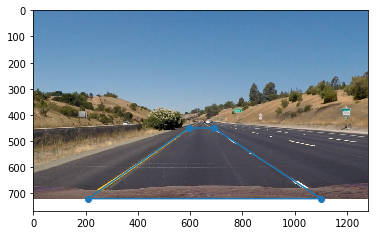

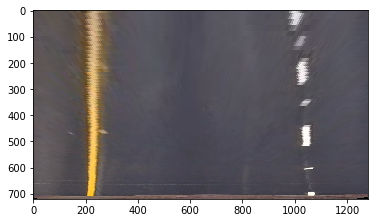

In [4]:
def warp_image(img,M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)



#Load straight lane lines image 
images = glob.glob('../test_images/straight_lines*.jpg')
img = mpimg.imread(images[0])

plt.figure()
plt.imshow(img)

offset = 225 # offset for dst points
img_size = (img.shape[1], img.shape[0])


# # # For source points I'm selecting four corners of a trapezoid

src = np.float32([(595,450),(690,450),(1100,720) ,(210,720)])

# # # Code used to select source points by eyeballing 
x=[]
y=[]
for point in src:
    x.append(point[0])
    y.append(point[1])

x.append(src[0][0])
y.append(src[0][1])
plt.scatter(x,y)
plt.plot(x, y)
# # For destination points, I'm choosing some points to be
# # arranged in a rectangle and fit the offset value 

dst = np.float32([[offset, 0], [img_size[0] - offset, 0], 
                             [img_size[0]-offset, img_size[1]], 
                             [offset, img_size[1]]])
# print("src:")
# print(src)
# print("dst:")
# print (dst)
# # Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
M_inv= cv2.getPerspectiveTransform(dst,src)
# # Warp the image using OpenCV warpPerspective()
warped = warp_image(img, M)
plt.figure()
plt.imshow(warped)


# # # Testing perspective transform on second straight lane lines image
# img = mpimg.imread(images[1])
# img= cv2.undistort(img, mtx, dist, None, mtx)
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
# x=[]
# y=[]
# for point in src:
#     x.append(point[0])
#     y.append(point[1])

# x.append(src[0][0])
# y.append(src[0][1])

# f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

# ax1.set_title("Undistorted Image")
# ax1.imshow(img)
# ax1.scatter(x,y)
# ax1.plot(x, y)
# ax2.set_title("Undistorted and Warped Image")
# ax2.imshow(warped)
# x= [255,1055,1055,255,255]
# y= [0,0,720,720,0]
# ax2.scatter(x,y)
# ax2.plot(x,y)
# fname='../pipeline/warped_straight_lines.jpg'
# f.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='jpg',
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)






# # # Testing perspective transform on curved lane lines image
# img = mpimg.imread(glob.glob('../test_images/test2.jpg')[0])
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(warped)



binary_warped_images=[]
for bin_img in binary_threshold_images:
    binary_warped = warp_image(bin_img,M)
    binary_warped_images.append(binary_warped)
#     plt.figure()
#     plt.imshow(bin_img, cmap='gray')
#     plt.figure()
#     plt.imshow(binary_warped, cmap='gray')


## Fifth, I'll detect lane pixels and fit to find the lane boundary.

In [5]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low =  rightx_current-margin
        win_xright_high =  rightx_current+margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (len(good_left_inds)>=minpix):
            #recenter left
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds)>=minpix):
            #recenter right
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx , 2)
    right_fit = np.polyfit(righty,rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
# #     uncomment to plot the left and right polynomials on the lane lines 
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     fname='../pipeline/color_fit_lines.jpg'
#     plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format='jpg',
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

    
    
    return out_img,left_fit,right_fit,left_fitx,right_fitx, ploty

poly_fits = []
for img in binary_warped_images:
#     plt.figure()
#     plt.imshow(img)
    out_img,left_fit,right_fit,left_fitx,right_fitx, ploty= fit_polynomial(img)
#     plt.figure()
#     plt.imshow(out_img)
    poly_fits.append([left_fit,right_fit,out_img.shape,left_fitx,right_fitx])
   



    

## Sixth, I'll determine the curvature of the lane and vehicle position with respect to center.

In [6]:
def measure_real_curvature_and_offset(left_fit,right_fit,img_shape):
    '''
    Calculates the curvature of polynomial functions and the offset of the vehicle in meters. 
    '''
    #Note fix corrected parabola. not scaling correctly 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension


    # Fit a second order polynomial to pixel positions in each fake lane line

    left_fit_cr = [(xm_per_pix/(ym_per_pix**2))*left_fit[0],(xm_per_pix/ym_per_pix)*left_fit[1],left_fit[2]*xm_per_pix]
    
    right_fit_cr = [(xm_per_pix/(ym_per_pix**2))*right_fit[0],(xm_per_pix/ym_per_pix)*right_fit[1],right_fit[2]*xm_per_pix]
    ploty = np.linspace(0, img_shape[1]-1, img_shape[1])
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    #####  calculation of R_curve (radius of curvature) #####

    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2))/(np.abs(2*left_fit_cr[0]))
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2))/(np.abs(2*right_fit_cr[0]))
    
    ## Calculate vehicle position relative to lane center at the base of the image 
    y = y_eval
    x_pos_left= (y**2)*left_fit_cr[0]+y*left_fit_cr[1]+left_fit_cr[2]
    x_pos_right=(y**2)*right_fit_cr[0]+y*right_fit_cr[1]+right_fit_cr[2]
    x_img_center= img_shape[0]*xm_per_pix/2
    x_lane_center=((x_pos_left)+(x_pos_right))/(2)
    vehicle_position=x_img_center-x_lane_center
    return left_curverad, right_curverad,vehicle_position


curverads=[]
vehicle_positions=[]
for i in range(0,len(undistorted_images)):
    img=undistorted_images[i]
    img_shape= [img.shape[1],img.shape[0]]
    left_curverad, right_curverad, vehicle_position= measure_real_curvature_and_offset(poly_fits[i][0],poly_fits[i][1],img_shape)
    curverads.append((left_curverad,right_curverad))
    vehicle_positions.append(vehicle_position)
#     print(left_curverad, 'm', right_curverad, 'm', vehicle_position, 'm')

## Seventh, I'll warp the detected lane boundaries back onto the original image.

In [7]:
def project_lane_boundaries_on_original(undist, warped, M_inv, right_fitx, left_fitx, ploty):
    #Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result 
    

    


## Eighth, I'll overlay on the image:
## a) a visual display of the lane boundaries
## b) a numerical estimation of lane curvature 
## c) the vehicle position

In [14]:
def overlay_output_on_original_image(undist,warped,right_fitx,left_fitx,left_curve_rad,right_curve_rad,vehicle_position):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    comb_img = project_lane_boundaries_on_original(undist, warped, M_inv, right_fitx, left_fitx, ploty)
    lane_curvature=(left_curve_rad+right_curve_rad)/2

    cv2.putText(comb_img,"radius of curvature: {} m".format(lane_curvature),(100,100),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1, color= (0,0,255))
    cv2.putText(comb_img,"vehicle position relative to lane center: {} m".format(vehicle_position),(100,200),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color= (0,0,255))
    return comb_img 


## Now, I'll define the image processing pipeline 

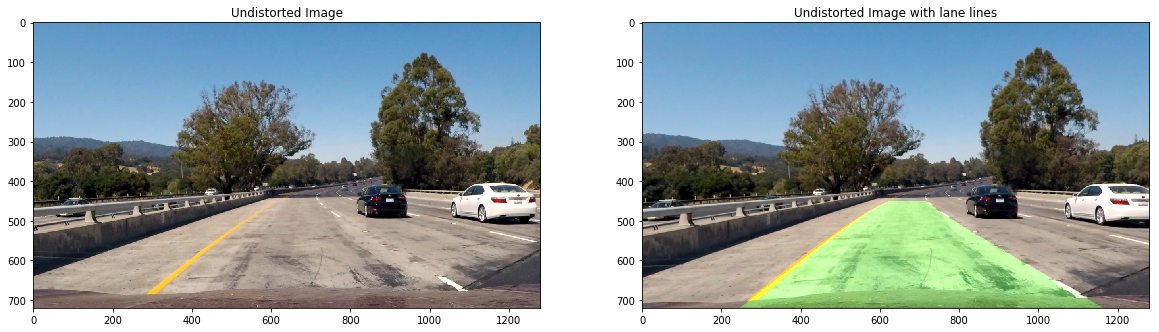

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    img_shape=[image.shape[1],image.shape[0]]
    #Step 1: Undistort the image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    #Step 2: Run color and gradient threshold on the image to produce a binary threshold image
    binary_threshold_image = create_binary_threshold_image(undist)
#     plt.figure()
#     plt.imshow(binary_threshold_image)

    #Step 3: Warp the binary threshold image to birds eye view
    warped= warp_image(binary_threshold_image, M)
    
    #Step 4,5: Detect lane line pixels on the warped binary image and Fit a Polynomial to each lane line 
    out_img,left_fit,right_fit,left_fitx,right_fitx, fity = fit_polynomial(warped)

    
    #Step 6: Calculate lane curvature and vehicle position in meters
    left_curve_rad, right_curve_rad, vehicle_position = measure_real_curvature_and_offset(left_fit,right_fit,img_shape)
    

    #Step 7: Draw the lines,curvature, and vehicle position on the original(undistorted) image
    combo = overlay_output_on_original_image(undist,warped,right_fitx,left_fitx,left_curve_rad,right_curve_rad,vehicle_position)
    return combo


img = mpimg.imread('../test_images/test1.jpg')
processed_img = process_image(img)

fname='../pipeline/final_output.jpg'



f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title("Undistorted Image")
ax1.imshow(img)
ax2.set_title("Undistorted Image with lane lines")
ax2.imshow(processed_img)
f.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='jpg',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


## Running the project video through the pipeline

In [26]:
video_output = 'transformed_project_video.mp4'
# clip1 = VideoFileClip('../project_video.mp4').subclip(0,5)
clip1 = VideoFileClip('../project_video.mp4')
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video transformed_project_video.mp4
[MoviePy] Writing video transformed_project_video.mp4


100%|█████████▉| 1260/1261 [05:58<00:00,  3.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: transformed_project_video.mp4 



In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Running the project challenge video through the pipeline:


In [ ]:
video_output = 'challenge_result.mp4'
clip1 = VideoFileClip('../challenge_video.mp4').subclip(0,5)
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))